# Taking off the Training Weels: Re-Balancing the Citibike System

**Author: Mitchell Krieger**
***

## Modeling

These models attempt to predict how many bikes are availble at a given station at a given time. Starting by isolating a typical 2 week interval to see if models are able to capture both daily and weekly seasonality. June 17th - June 30th, 2018 was chosen for its good weather, lack of significant holidays, and consistency of data collection across all stations (no missing values). Yearly seasonality will be set aside for now.

**Importing Relevant Packages**

In [79]:
import requests
import warnings
import json
import sys, os 
import numpy as np
import datetime as dt
import pandas as pd
import itertools


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
plt.style.use('seaborn')

from cleaning import *
from station import *
from model_diagnostics import evaluate_ts
from hidden_printing import Hidden_Printer
import pickle

### Check for stationarity

Before modeling can begin, we need to ensure that each time series is stationary. Using the Dickey-Fuller test, we'll test for stationarity and isolate stations that are not. In addition, data will be resampled hourly to prep for models that require it.

In [3]:
#load in data and transform to a resampled hourly time x station matrix in a dataframe
year_2018 = pickle.load(open('./pickle/historical.pickle','rb'))
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()
station_mat.columns = [str(col) for col in station_mat.columns]


#interpolate timeseries with small amounts of  missing values
station_mat = station_mat.interpolate()

#drop station colums that have large amount of missing data due to installation/discontinuation 
# or major malfunction in 2018
station_drop = list(station_mat.isna().sum().sort_values(ascending=False).head(45).index)
station_mat.drop(columns=station_drop,inplace=True)

station_mat.head()

,72,79,82,83,116,119,120,127,128,143,...,3478,3481,3486,3489,3490,3491,3492,3493,3494,3495
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13.0,4.0,3.0,30.0,0.0,12.0,7.0,5.0,10.5,12.5,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 01:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 02:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 03:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,...,16.0,6.5,14.0,5.0,5.0,13.0,16.0,11.5,17.0,20.0
2018-01-01 04:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,...,16.0,6.0,14.0,5.0,5.0,13.0,16.0,12.0,17.0,20.0


**Dickey-Fuller Test**

Here we will iterate over columns and store result of test in dataframe. A value of True means that the null hypothesis of the dickey fuller test as been rejected, implying stationarity. This doesn't garuantee stationarity but it gives us an idea of how many stations are extremely unstationary.

In [4]:
dickey_results = pd.Series()

with Hidden_Printer(): #supresses Dickey-Fuller function's print
    
    for col in station_mat.columns:
      dftest = dickey_fuller(station_mat[col])
      dickey_results[col] = dftest


dickey_results.value_counts()

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


True     656
False      8
dtype: int64

Only 8 stations failed the dickey fuller test. Taking a closer look at each one by plotting them:

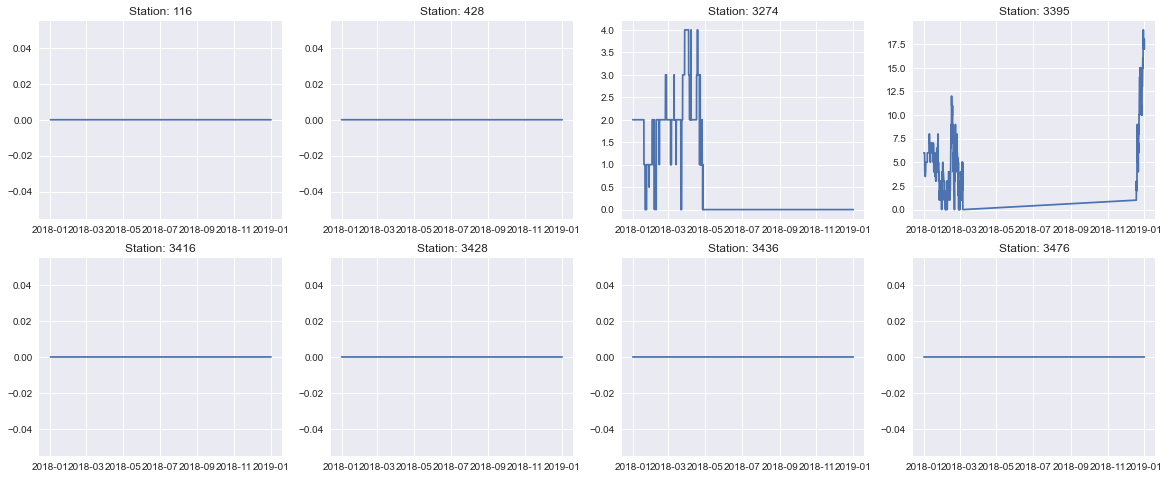

In [5]:
investigate = dickey_results.loc[dickey_results == False]

fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(20,8))

for i, ts in enumerate(investigate.index):
  ax[i//4][i%4].plot(station_mat[ts])
  ax[i//4][i%4].set_title(f'Station: {ts}')

It seems these fail the dickey-fuller test because they are actually stations that should have been dropped due to their lack of data. We'll remove them from out station matrix

In [6]:
station_mat.drop(columns=investigate.index,inplace=True)

### The Typical Station

For our inital models we'll use Station 3172 on the Upper West stide as our training data to examine the intricacies of station time series during our two week interval of June 17th - June 30th, 2018.

In [7]:
station_3172 = Station(3172)
station_3172.info()


        #### Station 3172 Info ####
        
        Name: W 74 St & Columbus Ave
        Status: active
        Legacy ID: 3172
        Type: classic
        Region: NYC District 
        Coordinates: (40.7785669,-73.97754961)
        Rental Methods: ['CREDITCARD', 'KEY']
        Has Kiosk: True
        
        #### Bike Stats ####
        
        As of: 2020-12-16 18:32:59
        Capacity: 27
        Available Bikes: 6
        Available Docks: 20
        Disabled Bikes: 1
        Disabled Docks: 0
        


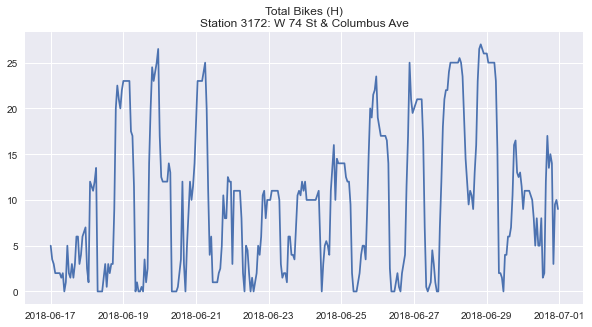

In [8]:
station_3172.plot_avail_bikes(time_interval=('2018-06-17','2018-06-30'))

You can see the typical weekly and daily seasonailty found in the Exploratory data analysis in this plot. On weekdays during the morning the morning there are many bikes taken from the station and then they are returned in the evening. Traffic on weekends is slower and Tuesdays, Wednesday and Thursdays are the most active days.

Using seasonal decomposition to be more isolate about this trend:`

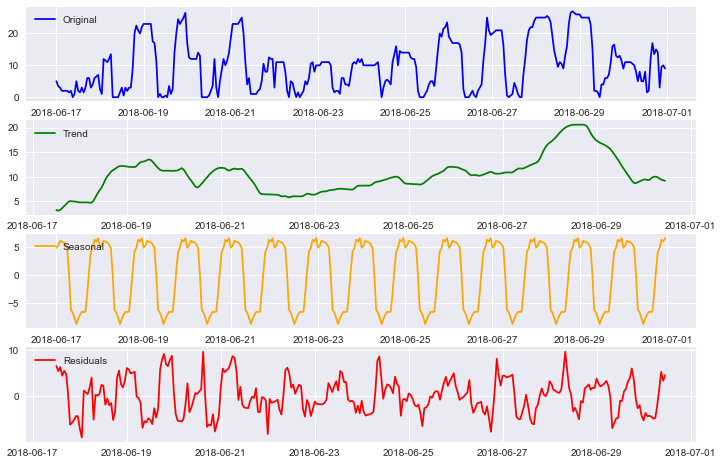

In [10]:
station_3172.availbike_decompose(time_interval=('2018-06-17','2018-06-30'))

The trend line somewhat shows the weekly seasonality, but doesn't capture it completely. The last weekend in June is also Pride weekend, which would be causing some of the irregularies in the daily and weekly seasonality on those days.

For modeling purposes, we'll get the time series itself from the station class:

In [55]:
train_ts = station_3172.avail_bikes_ts(time_interval=('2018-06-17','2018-06-30'))
test_ts = station_3172.avail_bikes_ts(time_interval=('2018-07-03 15:00','2018-07-14')).interpolate()

## Dummy Model

To get a baseline model we'll create a dummy model that predicts a constant value for all future timesteps. To do so, we'll use 0 AR terms and 0 MA terms to find the future value.

In [89]:
arima = ARIMA(train_ts, order=(0,0,0),enforce_invertibility=False,enforce_stationarity=False)
results = arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            avail_bikes   No. Observations:                  336
Model:                          ARIMA   Log Likelihood               -1172.114
Date:                Thu, 17 Dec 2020   AIC                           2348.227
Time:                        11:43:45   BIC                           2355.855
Sample:                    06-17-2018   HQIC                          2351.268
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1416      0.494     20.523      0.000       9.173      11.110
sigma2        64.0594      7.611      8.417      0.000      49.143      78.976
===================================================================================
Ljung-Box (Q):                     2053.37   Jarque-Bera (JB):                24.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.48
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our baseline AIC value is 2348.227 which we will use to compare furture SARIMA models. The model diagnostic plots below show that our model is performing poorly because of the high correlation still present in the correlogram and our residuals are not normally distributed.

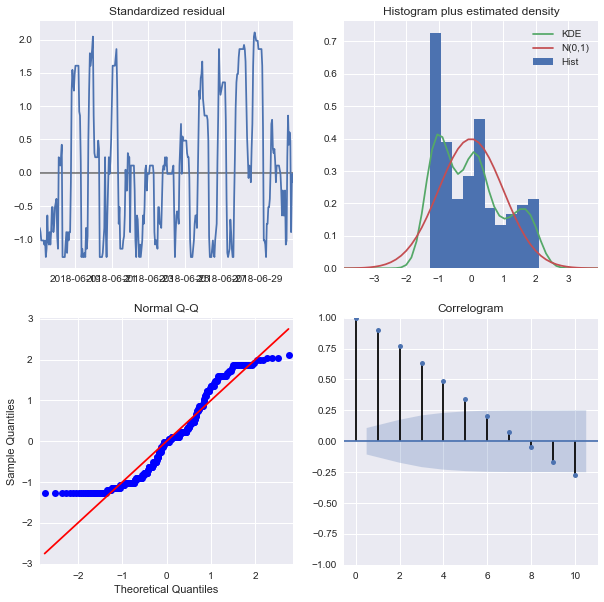

In [90]:
results.plot_diagnostics(figsize = (10,10));



#### Plotting the Dummy model

Using the dummy modelt to predict two weeks into the future and calculate the rmse on the future as the test set. Note the missing values. Our test will begin after the gap.

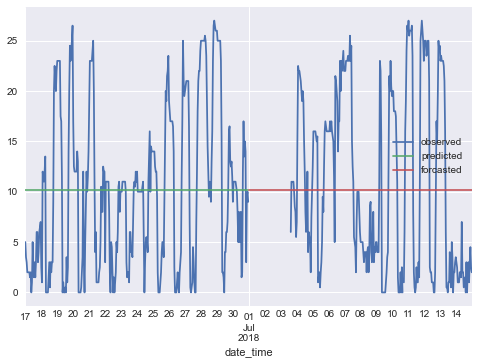

In [91]:
#get predictions

pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=True,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=24*14)
for_conf = forcast.conf_int()

ax = station_3172.avail_bikes_ts()['2018-06-17':'2018-07-14'].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)


plt.legend();

While using this constant value yeilds a decent RMSE and MAE scores on the train and test sets. This makes sense because there the capacity of the bike station does not change, so a mean value should actually be a decent predictor. Future models that perform well should decrease the value of both of these metrics.

In [93]:
from evaluation import rmse_mae

print('Train:')
rmse_mae(train_ts,pred.predicted_mean)

print('Test: ')
rmse_mae(test_ts,forcast.predicted_mean['2018-07-03 15:00':])

Train:
RMSE: 7.996735044113908
MAE:  6.668103163050874

Test: 
RMSE: 8.971522785081762
MAE:  8.056437798887124



The ACF and PACF plots of our train set indicate that adding seasonality and increasing both the AR terms and the MA terms may increase model performance.

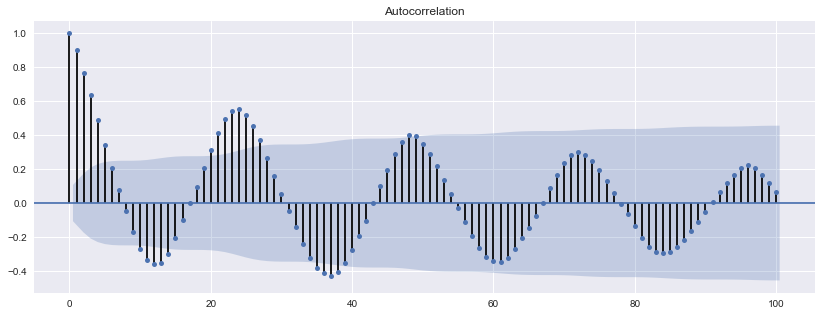

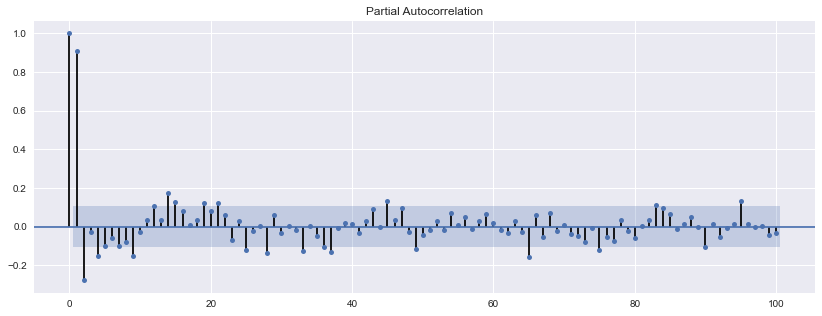

In [25]:
rcParams['figure.figsize'] = 14, 5
plot_acf(train_ts, lags=100);
plot_pacf(train_ts, lags=100);

## SARIMA Model

In order to capture the seasonality of the model, next we'll try SARIMA using a period of 24 to capture daily seasonality.

Setting up a grid search to find the best AR(p), Differincing (d) and MA(q) terms for both the trend and seasonality:

In [34]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

np.random.seed(7)


#Generate combinations of the number of AR(p), MA(q), and Differencing (d) terms
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))

#Generate combinations of seasonal AR(p), MA(q), and Differencing (d) terms
pdqs = [(x[0], x[1], x[2], 24) for x in pdq] 
count = 1

##grid search parameters using generated list of combinations
models=[]
for comb in pdq:
    for combs in pdqs:
        try:
            #try model
            arima = SARIMAX(ts, order=comb, seasonal_order=combs,
                          enforce_invertibility=False,enforce_stationarity=False)
            model = arima.fit()
            arima.fit()
            
            #append results to list
            models.append([comb,combs,model.aic])
            count += 1
        except:
            continue #skip order combination if error

#create data frame of model performance from list and sort by best AIC values
models_df = pd.DataFrame(models, columns=['pdq', 'pdqs', 'aic'])
models_df.sort_values('aic').head(20)


/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/o

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,pdq,pdqs,aic
386,"(1, 1, 2)","(0, 2, 2, 24)",1279.498264
305,"(1, 0, 2)","(0, 2, 2, 24)",1279.725411
278,"(1, 0, 1)","(0, 2, 2, 24)",1279.793646
629,"(2, 1, 2)","(0, 2, 2, 24)",1281.054609
548,"(2, 0, 2)","(0, 2, 2, 24)",1281.172763
521,"(2, 0, 1)","(0, 2, 2, 24)",1281.755760
287,"(1, 0, 1)","(1, 2, 2, 24)",1281.793625
467,"(1, 2, 2)","(0, 2, 2, 24)",1282.125600
710,"(2, 2, 2)","(0, 2, 2, 24)",1282.239199
557,"(2, 0, 2)","(1, 2, 2, 24)",1284.046100


In the sorted dataframe above we see that the model with the best AIC score brought the AIC score down significantly from the dummy model, indicating that this new seasonal model may perform better on the RMSE metric as well. This new model has has 1 AR, 1 Diff, and 2 MA terms and 2 seasonal diff, and 2 seasonal MA terms. However, only the first AR term and first MA term tern out to be statistically significant. This makes sense considering how close in value the AIC Scores are of the top 20 models, in other words those additional terms may not be helping the model significantly with p-values of less than 0.05

In [99]:
best_sarima = SARIMAX(ts, order=(1,1,2),seasonal_order=(0,2,2,24),
                    enforce_invertibility=False,enforce_stationarity=False)
results = best_sarima.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        avail_bikes   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(0, 2, 2, 24)   Log Likelihood                -633.749
Date:                            Thu, 17 Dec 2020   AIC                           1279.498
Time:                                    11:51:19   BIC                           1300.281
Sample:                                06-17-2018   HQIC                          1287.876
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8093      0.076     10.718      0.000       0.661       0.957
ma.L1         -0.8083      0.102     -7.902      0.000      -1.009      -0.608
ma.L2         -0.1398      0.074     -1.884      0.060      -0.285       0.006
ma.S.L24      -1.8534     36.534     -0.051      0.960     -73.459      69.752
ma.S.L48       0.8542     31.173      0.027      0.978     -60.243      61.951
sigma2         8.5938    314.227      0.027      0.978    -607.280     624.467
===================================================================================
Ljung-Box (Q):                       24.04   Jarque-Bera (JB):                12.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.07
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model diagnostics look much better than the dummy model, the residuals are clost to normally distributed and the correlogram shows no statistically significant correlations. 

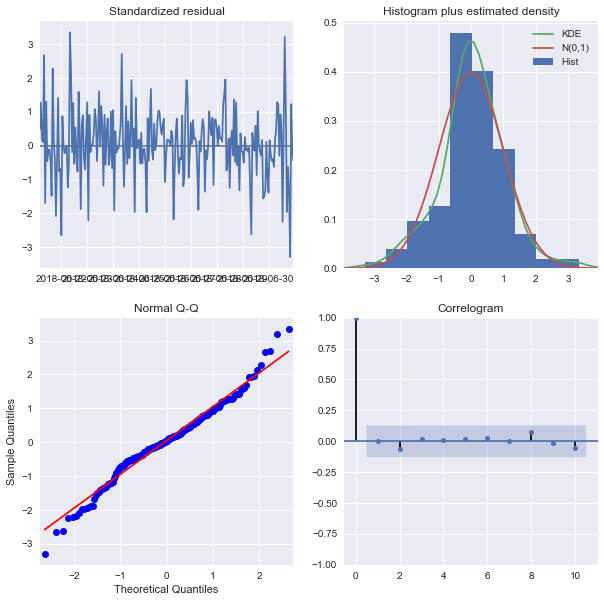

In [100]:
results.plot_diagnostics(figsize = (10,10));

#### Plotting SARIMA

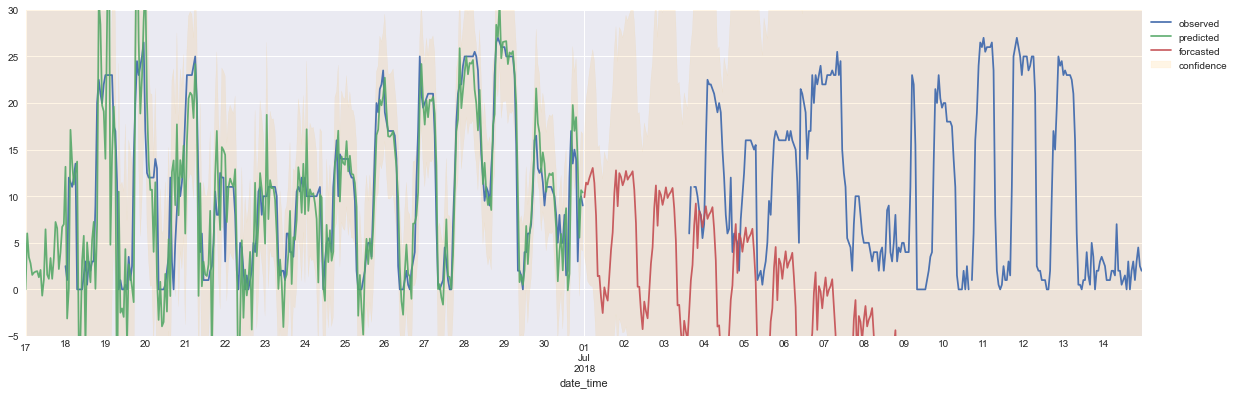

In [101]:
#get predictions
pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=False,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=336)
for_conf = forcast.conf_int()

rcParams['figure.figsize'] = 20, 6

#plot train and test
ax = station_3172.avail_bikes_ts()['2018-06-18':'2018-07-14'].plot(label='observed')

#plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:,1], color='orange',alpha=0.1, label='confidence')
ax.fill_between(for_conf.index,
               for_conf.iloc[:, 0],
               for_conf.iloc[:,1], color='orange',alpha=0.1)

#plot predictions
pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)

#focus window
ax.set_ylim(bottom=-5, top=30)

#move legend outside of plot
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

Based on this plot, this model seems to be extremely overfit and identified a non-existent downward trend. We can see the overfitting in the model's close capturing of the train data (both in confidence and in predicted value), but complete miss of the test set. This overfitting is also shown by the decreased the RMSE and the MAE on the train set from the dummy model, but increased on the test set.:

In [102]:
print('Train:')
rmse_mae(train_ts,pred.predicted_mean)

print('Test: ')
rmse_mae(test_ts,forcast.predicted_mean['2018-07-03 15:00':])

Train:
RMSE: 4.966456395968072
MAE:  3.367541757945296

Test: 
RMSE: 28.526738041576774
MAE:  25.44658195568028



### SARMIMA without statically insigificant terms

Let's try the SARIMA again but removing some of the differencing due to remove the downward trend:

In [131]:
best_sarima = SARIMAX(ts, order=(1,0,1),seasonal_order=(0,2,2,24),
                    enforce_invertibility=False,enforce_stationarity=False)
results = best_sarima.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             avail_bikes   No. Observations:                  336
Model:             SARIMAX(1, 0, 1)x(1, 2, [1, 2], 24)   Log Likelihood                -634.897
Date:                                 Thu, 17 Dec 2020   AIC                           1281.794
Time:                                         12:04:09   BIC                           1302.627
Sample:                                     06-17-2018   HQIC                          1290.190
                                          - 06-30-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8454      0.040     21.286      0.000       0.768       0.923
ma.L1          0.1350      0.072      1.885      0.059      -0.005       0.275
ar.S.L24   -5.842e-07      0.081  -7.18e-06      1.000      -0.160       0.160
ma.S.L24      -1.8766     65.436     -0.029      0.977    -130.128     126.375
ma.S.L48       0.8761     57.377      0.015      0.988    -111.581     113.333
sigma2         8.1589    533.474      0.015      0.988   -1037.430    1053.748
===================================================================================
Ljung-Box (Q):                       22.85   Jarque-Bera (JB):                11.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model has a very similar AIC score to the last and the diagnostics are also similar:

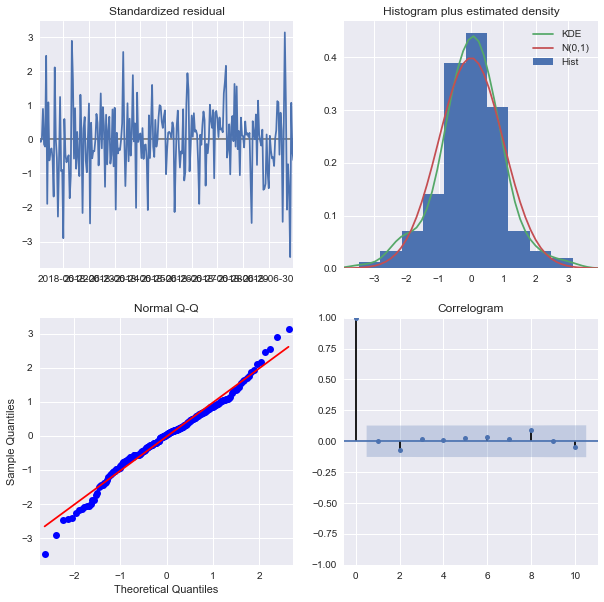

In [132]:
results.plot_diagnostics(figsize = (10,10));

When we plot it we see a much better capture of the flat trend, although this model seems to pick up on a multiplicative seasonality and doesn't capture the weekly. In addition, the condifence on the test set captures a daily cycle, but has a wide range of values if could exist in.

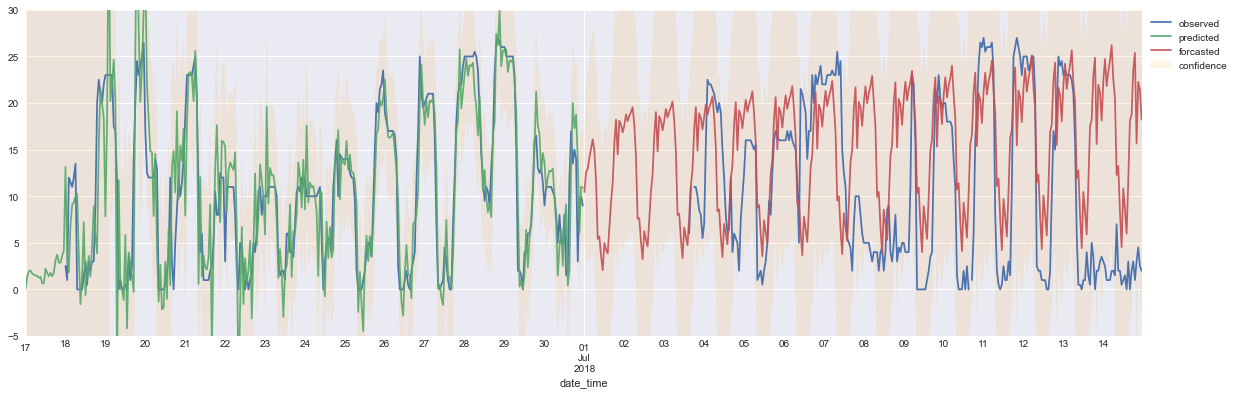

In [133]:
#get predictions
pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=False,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=336)
for_conf = forcast.conf_int()

rcParams['figure.figsize'] = 20, 6

#plot train and test
ax = station_3172.avail_bikes_ts()['2018-06-18':'2018-07-14'].plot(label='observed')

#plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:,1], color='orange',alpha=0.1, label='confidence')
ax.fill_between(for_conf.index,
               for_conf.iloc[:, 0],
               for_conf.iloc[:,1], color='orange',alpha=0.1)

#plot predictions
pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)

#focus window
ax.set_ylim(bottom=-5, top=30)

#move legend outside of plot
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

In [134]:
print('Train:')
rmse_mae(train_ts,pred.predicted_mean)

print('Test: ')
rmse_mae(test_ts,forcast.predicted_mean['2018-07-03 15:00':])

Train:
RMSE: 4.641054425904482
MAE:  3.196436010550174

Test: 
RMSE: 9.714560466135735
MAE:  7.772720234193785



The train metrics perform similarly to the first SARIMA. Interestingly, the test RMSE performs a little worse where as the test MAE performs a little better. In addition, still the model does not capture weekly seasonality at all, we'll attempt some other kinds of models to try to capture this behavior:

## Recurring Neural Network (RNN) using Long Short Term Memory (LSTM)

Using the DarTS package, we'll build a RNN network using LSTM.

In [135]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape, rmse, mae

First, we need to prep the data for DarTS and the RNN by creating `TimeSeries` objects and scaling them:

In [190]:
#create Time Series object

ts = TimeSeries.from_dataframe(station_mat.interpolate().reset_index(),'date_time',['3172'])

#create train, validadtion and test sets using two week intervals without missing values
train = ts.slice(np.datetime64('2018-06-17'),np.datetime64('2018-06-30'))
valid = ts.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))
test = ts.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22'))

#rescale for modeling

scaler = Scaler()
train_scl = scaler.fit_transform(train)
valid_scl = scaler.transform(valid)
test_scl = scaler.transform(test)
ts_scl = scaler.transform(ts)

Running the RNN Model with some hyper parameters assigned through guess and check (will try grid search later):

In [161]:
#model architecture
lstm = RNNModel(
    model='LSTM',
    output_length=1, # number of output time-steps to predict
    hidden_size=25, # Number of features in last hidden state
    n_rnn_layers=3, # Number of stacked rnn layers.
    input_length=24*7, # Number of previous time stamps taken into account.
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, #Adam optimizer
    log_tensorboard=True,
    random_state=1
)

lstm.fit(training_series=train_scl, 
         val_training_series=valid_scl, 
         verbose=True)

Training loss: 0.0170, validation loss: 0.0635


Plotting the model over the validation and test series:

In [165]:
#get predictions
forecast = scaler.inverse_transform(lstm.predict(n=24*85))

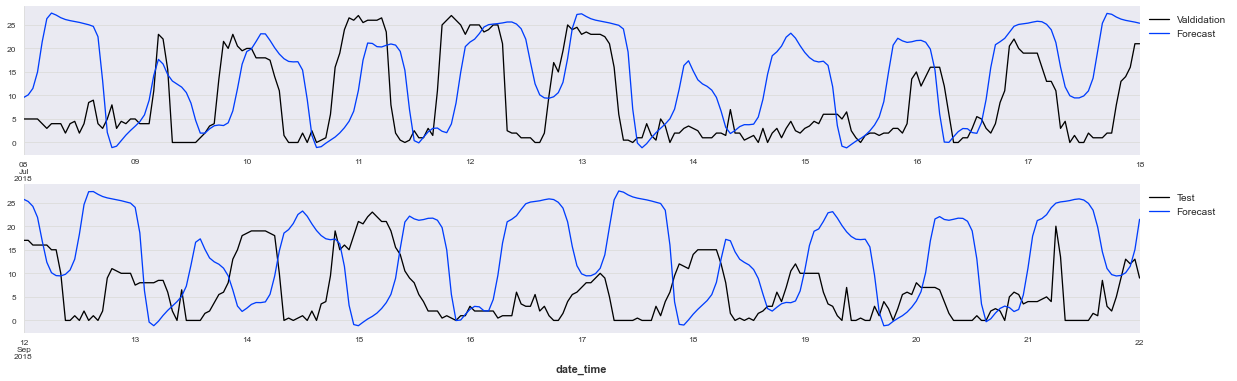

In [192]:
#validataion plot
fig, ax = plt.subplots(ncols=1,nrows=2)
valid.plot(ax=ax[0])
forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18')).plot(ax=ax[0])
ax[0].legend(['Valdidation','Forecast'],bbox_to_anchor=(1,1), loc="upper left");

#test plot
test.plot(ax=ax[1])
forecast.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22')).plot(ax=ax[1])
ax[1].legend(['Test','Forecast'],bbox_to_anchor=(1,1), loc="upper left");

The model does a better job on picking up on the weekly seasonality as evidenced by changing peaks. It looks like it only has a period of 4 which causes the curve to be off the daily cycle by September when the test set is. This is further evidenced by the RMSE and MAE:

In [197]:
print('Validation: ')
print('RMSE: ',rmse(valid,forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))))
print('MAE: ',mae(valid,forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))))

print('Test: ')
print('RMSE: ',rmse(test,forecast.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22'))))
print('MAE: ',mae(test,forecast.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22'))))

Validation: 
RMSE:  11.648948693251773
MAE:  9.193952218749217
Test: 
RMSE:  14.59635235364281
MAE:  12.146485001528907


This model performs was worse than the baseline dummy model and the previous SARIMA model. Future iterations of this model will need to have much better tuned hyper parameters. However, it was able to pick up on some differences in daily seasonality, albeit the wrong period.

## Facebook Prophet